<a href="https://colab.research.google.com/github/andr3w1699/Intelligent_System_for_Pattern_Recognition/blob/main/Assignement3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignement 3 (ISPR)
Selected assignement:

Assignment 4
DATASET (Airline reviews): https://www.kaggle.com/datasets/khushipitroda/airline-reviews

The dataset contains text of online travel reviews (in Column Review) with an associated Rating (column Overall_Rating). The objective is to train a classifier to predict the rating from the Review text. You are free to choose the model's architecture, but you should describe and justify your design choices.  Train the model and assess it as appropriate in machine learning. You are allowed to preprocess the data however you want (e.g. using pretrained embeddings, dropping some features, just a bag-of-words), but the predictive model must be trained by yourself from scratch (no pretrained predictor).

## Idea for the model architecture and processing pipeline
The goal of this assignment is to compare different sentiment classification models, all based on the use of Deep Learning models built on top of review embeddings.

First, models based on recurrent neural networks (RNN and gated variants) will be implemented, to do this the text sequences will be encoded as embedding sequences, ideally one for each word that constitutes the review, then a classifier based on RNN will be trained with an appropriate classification head.

Then will be tested another architecture, for each review, rather than having a sequence of embedding, we want a fixed embedding vector for each review. This will be obtained by mapping each token of the sentence in the corresponding embedding vector as before, and then somehow pool the embeddings of all the words in the review to get a single embedding vector for each review. On top of these fixed-size embeddings, I can use any deep model even for non-sequential data for the classification task.

As for embeddings, we experiment with both the default embeddings built by Keras and the pre-trained GloVE embeddings.


In [117]:
# needed libraries and import
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2
import re
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset and brief Data Understanding and Preprocessing

In [2]:
# load the dataset Airline_Reviews.csv on colab from local
uploaded = files.upload()

Saving Airline_Reviews.csv to Airline_Reviews.csv


In [88]:
# load the dataset on a Pandas dataframe
df = pd.read_csv('Airline_Reviews.csv')
df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

The column of the dataset we are interested in are  "Review" that we want to use to predict "Overall_Rating". Other columns that could be useful for our task are the column "Review_Title" which we can concatenate to the full review and the the columns Recommended that contains yes if the overall experience is recommended by the user, not otherwise, that we can use to do some check to clean the dataset.

In [90]:
# see which are the Rating values in column Overall_Rating
print(df['Overall_Rating'].unique())

['9' '1' '8' '2' '3' '5' '6' '7' '4' 'n']


In [91]:
# print the count of each rating values
print(df['Overall_Rating'].value_counts())

Overall_Rating
1    11595
2     2296
9     1768
8     1757
3     1356
7     1192
4      859
n      842
5      830
6      676
Name: count, dtype: int64


In [92]:
# type of elem in column Overall_Rating
print(df['Overall_Rating'].dtype)

object


In [93]:
# check for null values
print(df.isnull().sum())

Unnamed: 0                    0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64


In [94]:
# check for duplicated values
duplicates = df[df.duplicated()]
print(f"Total duplicate rows: {len(duplicates)}")

Total duplicate rows: 0


First thing we noticed is that:

1.   The Overall_Rating column takes values ​​from 1 to 9 and there are a bunch of missing values with values 'n' that we can remove
2.   The dataset is very unbalanced w.r.t. to this column since there are much much more low rating values e.g. 1,2.
3.   If we want to perform a binary classification task we need to partition the values ​​from 1 to 9 into two classes, one for negative reviews below a certain threshold and one for positive reviews above another threshold. We may consider to discard records with "neutral" values that are in the middle of these two classes.

In [95]:
# Remove all rows where Overall_Rating is 'n'
df = df[df['Overall_Rating'] != 'n']
print(df['Overall_Rating'].unique())

['9' '1' '8' '2' '3' '5' '6' '7' '4']


In [96]:
df['Overall_Rating'] = df['Overall_Rating'].astype(int)
print(df['Overall_Rating'].dtype)

int64


In [97]:
# Remove neutral reviews
df = df[df['Overall_Rating'] != 5]
print(df['Overall_Rating'].unique())

[9 1 8 2 3 6 7 4]


here we try to clean the dataset by removing those reviews that are not consistent, that is, they have a very low rating but are recommended or on the contrary they are not recommended despite having a high rating

In [98]:
# rows with low rating but recommended
inconsistent_low = df[(df['Overall_Rating'].astype(int) <= 4) & (df['Recommended'].str.lower() == 'yes')]
print("🤨 Low rating but recommended:")
inconsistent_low[['Overall_Rating', 'Recommended', 'Review']].head()

🤨 Low rating but recommended:


,Overall_Rating,Recommended,Review
15,1,yes,Frankfurt to Ljubljana. Flight was very comf...
23,1,yes,Two very short flights with Adria Airways fr...
31,1,yes,Tallinn to Stockholm with Adria Airways. Cle...
33,1,yes,Two short flights with Adria Airways (Ljublj...
41,1,yes,Excellent flights both ways with Adria Airways...


In [99]:
# how many are these incosistent line?
num_inconsistent_low = len(inconsistent_low)
print(f"Inconsistent (Low Rating, Recommended): {num_inconsistent_low}")

Inconsistent (Low Rating, Recommended): 2434


In [100]:
# rows with high rating but not recommended
inconsistent_high = df[(df['Overall_Rating'].astype(int) >= 6) & (df['Recommended'].str.lower() == 'no')]
print("🤔 High rating but not recommended:")
inconsistent_high[['Overall_Rating', 'Recommended', 'Review']].head()

🤔 High rating but not recommended:


,Overall_Rating,Recommended,Review
135,6,no,Larnaca to Athens. I fly Aegean twice weekly ...
237,6,no,There was nothing wrong with the flight itse...
283,6,no,I had paid $50 in advance (on top of my airf...
403,6,no,One of the best things about AR is that they...
508,8,no,Puerto Escondido to Mexico City on Aeromar. Sm...


In [101]:
num_inconsistent_high = len(inconsistent_high)
print(f"Inconsistent (High Rating, Not Recommended): {num_inconsistent_high}")

Inconsistent (High Rating, Not Recommended): 288


Want to remove this inconsistent line

In [102]:
# Define boolean masks for inconsistencies
mask_low = (df['Overall_Rating'].astype(int) <= 4) & (df['Recommended'].str.lower() == 'yes')
mask_high = (df['Overall_Rating'].astype(int) >= 6) & (df['Recommended'].str.lower() == 'no')

# Combine the two masks
inconsistent_mask = mask_low | mask_high

print(f"Original size: {len(df)}")

# Drop those rows from df
df = df[~inconsistent_mask].reset_index(drop=True)

print(f"New size after removing inconsistencies: {len(df)}")

Original size: 21499
New size after removing inconsistencies: 18777


In [103]:
# print the new count for each rating values
print(df['Overall_Rating'].value_counts())

Overall_Rating
1    9327
2    2264
9    1759
8    1722
3    1304
7    1130
4     777
6     494
Name: count, dtype: int64


Here some basic pre-processing

In [104]:
# Concatenate Review_Title with Review at the beginning, remove "" in the Title before concatenating
# The title may provide useful information about the sentiment of the review
df['Review'] = df['Review_Title'].str.strip('"') + ' ' + df['Review']

# Map Overall_Rating to Sentiment
def rating_to_sentiment(rating):
    if rating <= 4:
        return 'Negative'
    elif rating >= 6:
        return 'Positive'

# Apply the function to create the 'Sentiment' column
df['Sentiment'] = df['Overall_Rating'].apply(rating_to_sentiment)

# Convert to lowercase
df['Review'] = df['Review'].apply(lambda x: x.lower())

# Remove special characters (keep only letters, numbers, spaces and also !,?and .)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s!?.]', '', x))

# View the result
df[['Review', 'Overall_Rating', 'Sentiment']].head()

,Review,Overall_Rating,Sentiment
0,pretty decent airline moroni to moheli. turn...,9,Positive
1,not a good airline moroni to anjouan. it is a...,1,Negative
2,flight was fortunately short anjouan to dzao...,1,Negative
3,i will never fly again with adria please do ...,1,Negative
4,it ruined our last days of holidays do not bo...,1,Negative


# First Approach: Embedding + BidiLSTM

In [105]:
# Tokenize and pad
# Initialize a tokenizer that will keep only the 10,000 most frequent words.
# Any word not in the top 10,000 will be replaced with the "<OOV>" (out-of-vocabulary) token.
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
# Fit the tokenizer on the 'Review' column to learn the word frequencies and build the word index.
tokenizer.fit_on_texts(df['Review'])
# Convert each review into a sequence of integers, where each integer represents a word's index.
sequences = tokenizer.texts_to_sequences(df['Review'])
# Pad or truncate each sequence to ensure uniform length (200 tokens).
# Sequences longer than 200 are truncated at the end (post).
# Sequences shorter than 200 are padded with 0s at the beginning by default (can change with padding='post').
padded = pad_sequences(sequences, maxlen=200, truncating='post')

In [106]:
# Encode labels
# Initialize a label encoder to convert categorical sentiment labels (e.g., "positive", "negative") into integers.
label_encoder = LabelEncoder()
# Fit the label encoder on the 'Sentiment' column and transform the labels to numeric values.
labels = label_encoder.fit_transform(df['Sentiment'])

In [107]:
for i in range(5):  # print first 5 examples
    print(f"Review #{i+1}")
    print(f"Padded sequence: {padded[i]}")
    print(f"Label (encoded): {labels[i]}")
    print('-' * 50)

Review #1
Padded sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  483  593   29    1    3    1  670   79
    3   36    6  483  593   29  201  220  889  182  156    4   95    7
  348    4    2   64  635  182 1737  116    6   37  260    8   83  302
  119   51   38   38    5  110  502  194   26   13  133  757    3  447
   34    6  895   11  203    4  143 2717   59    5

so my dataset is made by the feature set, padded which is composed by padded token sequences  (shape: num_samples x 200)*  and  label the encoded sentiment labels that is the target array, made of integer-encoded sentiment labels.


\* Each of the 200 elements in a sample of padded is an integer index that refers to a specific word in your tokenizer’s vocabulary, and Keras handles the mapping automatically during training via the Embedding layer.

In [108]:
# Split the data into training and test sets
# 20% of the data goes to the test set
# Remember that the dataset is very unbalanced
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [109]:
# Compute class weights to handle imbalanced datasets
class_weights = compute_class_weight(
    # automatically calculate weights based on the frequency of each class.
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary format required by Keras
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.6855147864184009), 1: np.float64(1.84760147601476)}


In [110]:
# Define the model
model = Sequential([
    # Embedding layer turns word indices into dense vectors
    # input_dim is the size of the vocabulary
    # output_dim determine the size of the embedding vector
    # input_length is the  fixed length of the input sequences after padding/truncation
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    # Bidirectional LSTM to capture context from both directions
    # kernel_regularize is a regularization term that helps prevent overfitting by penalizing large weights in the network --> classical L2 regularization
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, kernel_regularizer=l2(0.001))),
    # Dropout layer for additional regularization
    Dropout(0.5),
    # Dense layer with ReLU activation
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    # Output layer: sigmoid for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
# binary_crossentropy is the correct loss function for binary classification with a sigmoid output.
# sparse_categorical_crossentropy is used for multi-class classification with softmax output.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 20% of training data used for validation
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict,  # Using class weight
    callbacks=[early_stopping]    # Using early stopping
)
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 313ms/step - accuracy: 0.6999 - loss: 0.6957 - val_accuracy: 0.8945 - val_loss: 0.3493
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.9298 - loss: 0.2419 - val_accuracy: 0.9351 - val_loss: 0.2356
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.9572 - loss: 0.1579 - val_accuracy: 0.9328 - val_loss: 0.2192
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 316ms/step - accuracy: 0.9674 - loss: 0.1261 - val_accuracy: 0.9288 - val_loss: 0.2351
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 322ms/step - accuracy: 0.9642 - loss: 0.1514 - val_accuracy: 0.9298 - val_loss: 0.2563
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9412 - loss: 0.1986
Test Accuracy: 0.9364


In [111]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs = model.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.94      0.96      2716
    Positive       0.86      0.92      0.89      1040

    accuracy                           0.94      3756
   macro avg       0.91      0.93      0.92      3756
weighted avg       0.94      0.94      0.94      3756


Macro Precision: 0.9144
Macro Recall:    0.9311
Macro F1-score:  0.9222


In [112]:
# compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[2561  155]
 [  84  956]]


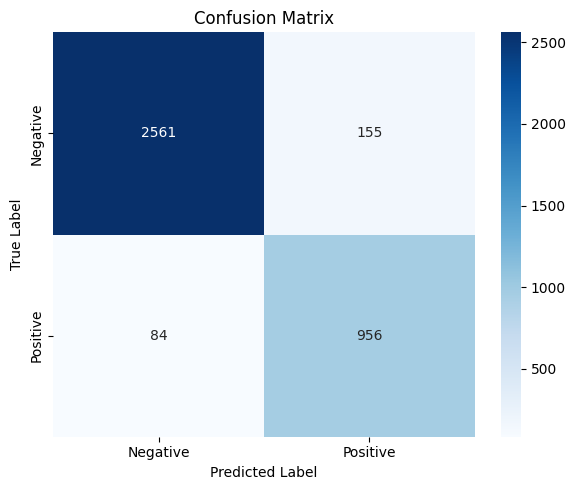

In [113]:
# Optional: Define class labels (e.g., "Negative" and "Positive")
labels = label_encoder.classes_  # or manually: labels = ['Negative', 'Positive']

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Second Approach: no Bidirectionality, Embedding + LSTM

In [114]:
# Define the model
model_LSTM = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(64, return_sequences=False, dropout=0.3, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_LSTM = model_LSTM.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate
test_loss_LSTM, test_acc_LSTM = model_LSTM.evaluate(X_test, y_test)
print(f"Test Accuracy (LSTM): {test_acc_LSTM:.4f}")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.6542 - loss: 0.6241 - val_accuracy: 0.9324 - val_loss: 0.2210
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 167ms/step - accuracy: 0.9364 - loss: 0.2228 - val_accuracy: 0.9111 - val_loss: 0.3127
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.9468 - loss: 0.1786 - val_accuracy: 0.9241 - val_loss: 0.2157
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9640 - loss: 0.1199 - val_accuracy: 0.9208 - val_loss: 0.2164
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - accuracy: 0.9759 - loss: 0.0997 - val_accuracy: 0.9062 - val_loss: 0.2665
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9413 - loss: 0.1797
Test Accuracy (LSTM): 0.9353


In [116]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs_LSTM = model_LSTM.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred_LSTM = (y_pred_probs_LSTM > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_LSTM, target_names=label_encoder.classes_))

precision_LSTM = precision_score(y_test, y_pred_LSTM, average='macro')
recall_LSTM = recall_score(y_test, y_pred_LSTM, average='macro')
f1_LSTM = f1_score(y_test, y_pred_LSTM, average='macro')

print(f"\nMacro Precision: {precision_LSTM:.4f}")
print(f"Macro Recall:    {recall_LSTM:.4f}")
print(f"Macro F1-score:  {f1_LSTM:.4f}")

cm_LSTM = confusion_matrix(y_test, y_pred_LSTM)
print("\nConfusion Matrix:")
print(cm_LSTM)

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.94      0.95      2716
    Positive       0.85      0.93      0.89      1040

    accuracy                           0.94      3756
   macro avg       0.91      0.93      0.92      3756
weighted avg       0.94      0.94      0.94      3756


Macro Precision: 0.9111
Macro Recall:    0.9342
Macro F1-score:  0.9215

Confusion Matrix:
[[2544  172]
 [  71  969]]


# Same setting but Vanilla/Elman RNN

In [118]:
# Define the model
model_RNN = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    SimpleRNN(64, return_sequences=False, dropout=0.3, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping, already defined before

# class_weight_dict already defined before

# Train the model
history_RNN = model_RNN.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss_RNN, test_acc_RNN = model_RNN.evaluate(X_test, y_test)
print(f"Test Accuracy (RNN): {test_acc_RNN:.4f}")

# Predict
y_pred_probs_RNN = model_RNN.predict(X_test)
y_pred_RNN = (y_pred_probs_RNN > 0.5).astype("int32").flatten()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RNN, target_names=label_encoder.classes_))

# Metrics
precision_RNN = precision_score(y_test, y_pred_RNN, average='macro')
recall_RNN = recall_score(y_test, y_pred_RNN, average='macro')
f1_RNN = f1_score(y_test, y_pred_RNN, average='macro')

print(f"\nMacro Precision: {precision_RNN:.4f}")
print(f"Macro Recall:    {recall_RNN:.4f}")
print(f"Macro F1-score:  {f1_RNN:.4f}")

# Confusion Matrix
cm_RNN = confusion_matrix(y_test, y_pred_RNN)
print("\nConfusion Matrix:")
print(cm_RNN)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.4623 - loss: 0.8068 - val_accuracy: 0.7451 - val_loss: 0.7325
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.6403 - loss: 0.6779 - val_accuracy: 0.8905 - val_loss: 0.3533
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.9082 - loss: 0.3161 - val_accuracy: 0.8676 - val_loss: 0.3699
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8562 - loss: 0.3578 - val_accuracy: 0.9038 - val_loss: 0.3176
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.9285 - loss: 0.2528 - val_accuracy: 0.8519 - val_loss: 0.3919
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9252 - loss: 0.2813
Test Accuracy (RNN): 0.9175
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94      2716
    Positive       0.83      0.88      0.85      1040

    accuracy                 

Embedding layer of Keras, how it works under the hood?
- At the start of training, each word index (from 0 to 9999) is assigned a random vector of size 64 (unless a specific initializer is provided).
- When you feed padded sequences (e.g., [0, 0, 3, 42, 8, ...]) into the network, the embedding layer looks up the corresponding rows in the embedding matrix for each index.

- So a sequence of length 200 becomes a (200, 64) matrix.

- During backpropagation, the embedding vectors are updated just like any other weights in the network.

- This way, words that are important to the classification task get vectors that capture semantic and contextual meaning, based on how they help reduce the loss (like binary cross-entropy in your case).

I want to make a comparison with petrained embedding e.g GloVe, Word2Vec that use pre-learned word vectors from huge corpora, Often offer better performances when training data is limited and in Keras, you can load them manually and freeze or fine-tune them.

# Use Glove pretrained embeddings + LSTM

In [119]:
# Downloading & Unzipping GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-05-07 13:40:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-07 13:40:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-07 13:40:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [120]:
# Load the GloVe embeddings
# This function is designed to load GloVe word embeddings from a text file, (the .txt file containing the pre-trained GloVe embeddings).
# The file path to the GloVe file is passed as an argument to the function.
def load_glove_embeddings(file_path):
    # python dictionary to store word embeddings
    # Key: The word (as a string)
    #
    embeddings_index = {}
    # open Glove file in read mode, ensures the file is properly encoded with UTF-8
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # structure of a line of GloVE file: word value1 value2 value3 ... valueN
            # line is split by spaces into individual parts
            values = line.split()
            # take the word
            word = values[0]
            # take the vector values
            coefs = np.asarray(values[1:], dtype='float32')
            # fill the dictionary
            embeddings_index[word] = coefs
    # return the dictionary
    return embeddings_index

# Load GloVe embeddings (use glove.6B.50d.txt or glove.6B.100d.txt, etc.)
embedding_dim = 200  # or 100, 200, 300 based on the downloaded file
glove_path = f'glove.6B.{embedding_dim}d.txt'
embeddings_index = load_glove_embeddings(glove_path)
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [123]:
# The word_index is a dictionary created by the Keras tokenizer.
# It contains the words from your training data as keys and their corresponding integer indices as values.
vocab_size = len(tokenizer.word_index) + 1  # number of unique words found in your dataset,  Plus 1 for padding token
# Matrix to Store Word Vectors
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding_matrix with Pre-trained GloVe Vectors
# iterates over every word in the word_index of the tokenizer
for word, index in tokenizer.word_index.items():
    # checks if the word exists in the embeddings_index dictionary
    if word in embeddings_index:
        # f the word is found in embeddings_index,
        # we set the corresponding row in embedding_matrix (at position index)
        # to the word's vector from embeddings_index.
        embedding_matrix[index] = embeddings_index[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (36304, 200)


In [127]:
# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200,
              weights=[embedding_matrix], trainable=True),

    # 🔹 New: Dropout entire word embeddings randomly
    SpatialDropout1D(0.3),  # <== Good before LSTM

    Bidirectional(LSTM(
        64,
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.3,  # <== Like in your reference
        kernel_regularizer=l2(0.001)
    )),

    Dropout(0.2),  # <== slightly earlier dropout before dense
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    Dropout(0.4),  # <== a stronger dropout after dense
    Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size=64, callbacks=[early_stopping] )

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 184s 816ms/step - accuracy: 0.7505 - loss: 0.8857 - val_accuracy: 0.9015 - val_loss: 0.3893
Epoch 2/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 210s 854ms/step - accuracy: 0.8757 - loss: 0.4350 - val_accuracy: 0.9202 - val_loss: 0.3219
Epoch 3/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 824ms/step - accuracy: 0.9149 - loss: 0.3208 - val_accuracy: 0.9381 - val_loss: 0.2558
Epoch 4/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 215s 883ms/step - accuracy: 0.9341 - loss: 0.2536 - val_accuracy: 0.9415 - val_loss: 0.2260
Epoch 5/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 190s 829ms/step - accuracy: 0.9506 - loss: 0.2047 - val_accuracy: 0.9408 - val_loss: 0.2149
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.9496 - loss: 0.2031
Test Accuracy: 0.9470


In [128]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs = model.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96      2716
    Positive       0.89      0.92      0.91      1040

    accuracy                           0.95      3756
   macro avg       0.93      0.94      0.93      3756
weighted avg       0.95      0.95      0.95      3756


Macro Precision: 0.9307
Macro Recall:    0.9384
Macro F1-score:  0.9344


In [129]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[2601  115]
 [  84  956]]


Fixed Embedding vector + MLP

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# 1. Create averaged embeddings for each review
def average_embedding(review, tokenizer, embeddings_index, embedding_dim):
    words = tokenizer.texts_to_sequences([review])[0]  # list of word indices
    valid_embeddings = []

    # Reverse tokenizer to get word from index
    index_word = {v: k for k, v in tokenizer.word_index.items()}

    for word_idx in words:
        word = index_word.get(word_idx)
        if word and word in embeddings_index:
            valid_embeddings.append(embeddings_index[word])

    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Apply to all reviews
review_vectors = np.array([
    average_embedding(text, tokenizer, embeddings_index, embedding_dim)
    for text in df_cleaned['Review']
])
print(f"Review vector shape: {review_vectors.shape}")  # Should be (num_reviews, embedding_dim)

# 2. Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_cleaned['Sentiment'])

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    review_vectors, labels, test_size=0.2, random_state=42
)


# 4. Build a simple feedforward classifier
model = Sequential([
    Dense(128, activation='relu', input_shape=(embedding_dim,), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(len(np.unique(labels)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Get class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict (Keras requires this format)
class_weights_dict = dict(enumerate(class_weights))

# Now pass it to model.fit()
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict  # 👈 here!
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Review vector shape: (19607, 200)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7064 - loss: 0.7248 - val_accuracy: 0.8094 - val_loss: 0.5591
Epoch 2/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8625 - loss: 0.4295 - val_accuracy: 0.8904 - val_loss: 0.3613
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8766 - loss: 0.3774 - val_accuracy: 0.8929 - val_loss: 0.3395
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8879 - loss: 0.3513 - val_accuracy: 0.8955 - val_loss: 0.3257
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8867 - loss: 0.3473 - val_accuracy: 0.8540 - val_loss: 0.4211
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8887 - loss: 0.3300 - val_accuracy: 0.8770 - val_loss: 0.3703
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8823 - loss: 0.3308 - val_accuracy: 0.8891 - val_loss: 0.3281
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8913 - loss: 0.3159 - val_accuracy: 0.8815 - val_

In [41]:
# Get predicted class labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Optional: precision, recall, f1 (macro-averaged)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.91      0.94      2907
    Positive       0.78      0.90      0.83      1015

    accuracy                           0.91      3922
   macro avg       0.87      0.90      0.88      3922
weighted avg       0.91      0.91      0.91      3922


Macro Precision: 0.8699
Macro Recall:    0.9047
Macro F1-score:  0.8847


# Results

# Conclusions and final considerations